# Author: Johanna & Tobias

# Dataset Exploration

In [2]:
import os 
from pathlib import Path
from dotenv import load_dotenv, find_dotenv

basepath = Path(os.getcwd())
# make sure your working directory is the repository root.
if basepath.name != "idp-radio-1":
    os.chdir(basepath.parent.parent)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import math
from skimage.transform import resize
os.getcwd()

'/srv/idp-radio-1'

In [3]:
load_dotenv(find_dotenv())

True

## Data Loading

In [4]:
chexpert_folder = Path(os.environ.get('CHEXPERT_DATASET_DIRECTORY'))

train_labels = pd.read_csv(chexpert_folder / "nofinding_train.csv")
test_labels = pd.read_csv(chexpert_folder / "test.csv")
#train_labels.fillna(0, inplace=True)

In [5]:
train_labels.head()

,Unnamed: 0,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,...,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,patient_id
0,0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,...,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN,2
2,2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,...,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2
3,3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,...,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2
4,4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,3


In [6]:
test_labels.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,patient_id
0,CheXpert-v1.0-small/valid/patient64541/study1/...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64541
1,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,64542
2,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Lateral,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,64542
3,CheXpert-v1.0-small/valid/patient64543/study1/...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64543
4,CheXpert-v1.0-small/valid/patient64544/study1/...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64544


First, we have a simple look at the pictures in the dataset. There are two kinds of views, lateral
and frontal. 

### Shape of dataset

In [7]:
print('Shape of train data:', train_labels.shape)
print('Shape of test data:', test_labels.shape)

Shape of train data: (223414, 21)
Shape of test data: (234, 20)


#### Patients

In [8]:
print('Number of unique patients train data:', train_labels.patient_id.unique().shape)
print('Avg. number of images per patient train data:',  train_labels.shape[0]  / train_labels.patient_id.unique().shape[0])
print('Number of unique patients test data:', test_labels.patient_id.unique().shape)
print('Avg. number of images per patient test data:',  test_labels.shape[0]  / test_labels.patient_id.unique().shape[0])

Number of unique patients train data: (64540,)
Avg. number of images per patient train data: 3.461636194607995
Number of unique patients test data: (200,)
Avg. number of images per patient test data: 1.17


#### Studies per patient

In [9]:
counts = train_labels.patient_id.value_counts()
count_df = pd.DataFrame()
count_df['id'] = counts.index
count_df['count'] = counts.to_list()
print("Train data")
print('Nr. of Studies | Patients')
print(count_df['count'].value_counts())
print(count_df['count'].median())

Train data
Nr. of Studies | Patients
1     22581
2     17547
3      6965
4      4685
5      2910
      ...  
73        1
74        1
80        1
75        1
64        1
Name: count, Length: 79, dtype: int64
2.0


In [10]:
counts = test_labels.patient_id.value_counts()
count_df = pd.DataFrame()
count_df['id'] = counts.index
count_df['count'] = counts.to_list()
print("Test data")
print('Nr. of Studies | Patients')
print(count_df['count'].value_counts())

Test data
Nr. of Studies | Patients
1    169
2     28
3      3
Name: count, dtype: int64


In [11]:
print('Number of Male/Female patients train data')
print(train_labels['Sex'].value_counts())
print(train_labels['Sex'].value_counts()[1]/train_labels['Sex'].value_counts().sum())
print('\nNumber of Male/Female patients test data')
print(test_labels['Sex'].value_counts())
print(test_labels['Sex'].value_counts()[1]/test_labels['Sex'].value_counts().sum())

Number of Male/Female patients train data
Male       132636
Female      90777
Unknown         1
Name: Sex, dtype: int64
0.40631741967826546

Number of Male/Female patients test data
Male      128
Female    106
Name: Sex, dtype: int64
0.452991452991453


In [12]:
print('Avg of Age patients train data')
print(train_labels['Age'].mean())
print(train_labels['Age'].median())
print(train_labels['Age'].std())
print('Avg of Age patients test data')
print(test_labels['Age'].mean())
print(test_labels['Age'].median())
print(test_labels['Age'].std())

Avg of Age patients train data
60.430653405784774
62.0
17.820924664000692
Avg of Age patients test data
60.79059829059829
62.5
18.554031908717217


#### Frontal vs. Lateral

In [14]:
print('Number of Frontal/Lateral images train data')
print(train_labels['Frontal/Lateral'].value_counts())
print(train_labels['Frontal/Lateral'].value_counts()[0]/sum(train_labels['Frontal/Lateral'].value_counts()))
print(train_labels['Frontal/Lateral'].value_counts()[1]/sum(train_labels['Frontal/Lateral'].value_counts()))
print('\nNumber of Frontal/Lateral images test data')
print(test_labels['Frontal/Lateral'].value_counts())
print(test_labels['Frontal/Lateral'].value_counts()[0]/sum(test_labels['Frontal/Lateral'].value_counts()))
print(test_labels['Frontal/Lateral'].value_counts()[1]/sum(test_labels['Frontal/Lateral'].value_counts()))

Number of Frontal/Lateral images train data
Frontal    191027
Lateral     32387
Name: Frontal/Lateral, dtype: int64
0.8550359422417575
0.14496405775824253

Number of Frontal/Lateral images test data
Frontal    202
Lateral     32
Name: Frontal/Lateral, dtype: int64
0.8632478632478633
0.13675213675213677


In [23]:

print('\nNumber of AP/PA images train data')
print(train_labels['AP/PA'].value_counts())
print(train_labels['AP/PA'].value_counts()[0]/sum(train_labels['AP/PA'].value_counts()))
print(train_labels['AP/PA'].value_counts()[1]/sum(train_labels['AP/PA'].value_counts()))
print('\nNumber of AP/PA images test data')
print(test_labels['AP/PA'].value_counts())
print(test_labels['AP/PA'].value_counts()[0]/sum(test_labels['AP/PA'].value_counts()))
print(test_labels['AP/PA'].value_counts()[1]/sum(test_labels['AP/PA'].value_counts()))


Number of AP/PA images train data
AP    161590
PA     29420
LL        16
RL         1
Name: AP/PA, dtype: int64
0.8459013647285463
0.15400964261596528

Number of AP/PA images test data
AP    169
PA     33
Name: AP/PA, dtype: int64
0.8366336633663366
0.16336633663366337


## Labels

In [24]:

labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
print(labels)

['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']


In [25]:
def get_label_distribution(data): 
    d = {'Pathology': [], 'Positive': [], 'Positive %': [], 'Uncertain': [], 'Uncertain %': [], 'Negative': [], 'Negative %': [], 'NaN': [], 'NaN %': [],}
    for label in labels:
        values = data.groupby(label)
        n_samples = data.shape[0]
        round_dec = 2
        d['Pathology'].append(label)

        positive = values.size()[1.0] if 1.0 in values.size() else 0
        positive_percent = positive / n_samples * 100
        d['Positive'].append(positive)
        d['Positive %'].append(round(positive_percent, round_dec))

        uncertain = values.size()[-1.0] if -1.0 in values.size() else 0
        uncertain_percent = uncertain / n_samples * 100
        d['Uncertain'].append(uncertain)
        d['Uncertain %'].append(round(uncertain_percent, round_dec))

        negative = values.size()[-0.0] if -0.0 in values.size() else 0
        negative_percent = negative / n_samples * 100
        d['Negative'].append(negative)
        d['Negative %'].append(round(negative_percent, round_dec))

        nan_count =  n_samples - positive - uncertain - negative
        negative_percent =  nan_count / n_samples * 100
        d['NaN'].append(nan_count)
        d['NaN %'].append(round(negative_percent, round_dec))
    df = pd.DataFrame(d)
    df = df.set_index('Pathology')
    return df


In [26]:
get_label_distribution(train_labels)

,Positive,Positive %,Uncertain,Uncertain %,Negative,Negative %,NaN,NaN %
Pathology,,,,,,,,
No Finding,22381,10.02,0,0.00,0,0.00,201033,89.98
Enlarged Cardiomediastinum,10798,4.83,12403,5.55,35625,15.95,164588,73.67
Cardiomegaly,27000,12.09,8087,3.62,30147,13.49,158180,70.80
Lung Opacity,105581,47.26,5598,2.51,26559,11.89,85676,38.35
Lung Lesion,9186,4.11,1488,0.67,23274,10.42,189466,84.80
Edema,52246,23.39,12984,5.81,38646,17.30,119538,53.51
Consolidation,14783,6.62,27742,12.42,41642,18.64,139247,62.33
Pneumonia,6039,2.70,18770,8.40,24022,10.75,174583,78.14
Atelectasis,33376,14.94,33739,15.10,23226,10.40,133073,59.56


In [27]:
get_label_distribution(test_labels)

,Positive,Positive %,Uncertain,Uncertain %,Negative,Negative %,NaN,NaN %
Pathology,,,,,,,,
No Finding,38,16.24,0,0.0,196,83.76,0,0.0
Enlarged Cardiomediastinum,109,46.58,0,0.0,125,53.42,0,0.0
Cardiomegaly,68,29.06,0,0.0,166,70.94,0,0.0
Lung Opacity,126,53.85,0,0.0,108,46.15,0,0.0
Lung Lesion,1,0.43,0,0.0,233,99.57,0,0.0
Edema,45,19.23,0,0.0,189,80.77,0,0.0
Consolidation,33,14.10,0,0.0,201,85.90,0,0.0
Pneumonia,8,3.42,0,0.0,226,96.58,0,0.0
Atelectasis,80,34.19,0,0.0,154,65.81,0,0.0


<AxesSubplot:xlabel='Pathology'>

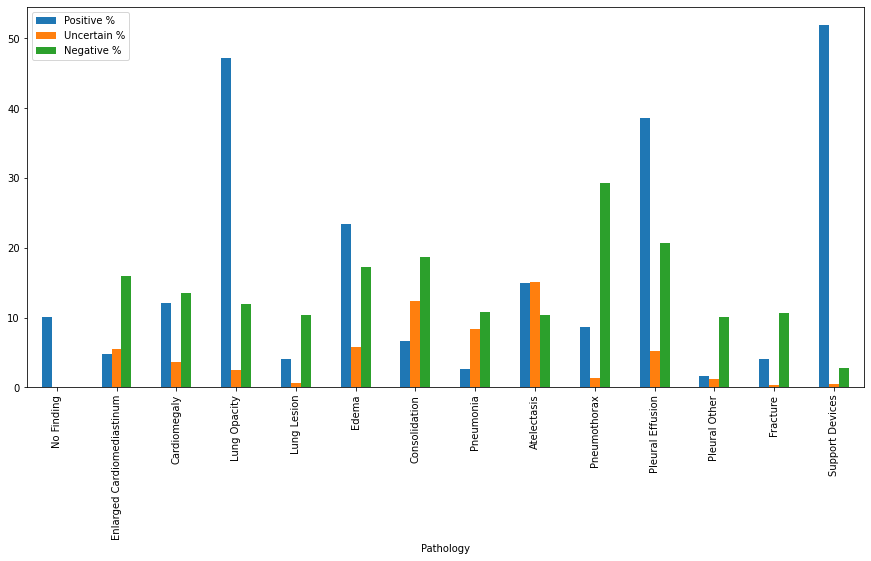

In [31]:
get_label_distribution(train_labels)[['Positive %', 'Uncertain %', 'Negative %']].copy().plot(kind='bar', figsize=(15,7))

<AxesSubplot:xlabel='Pathology'>

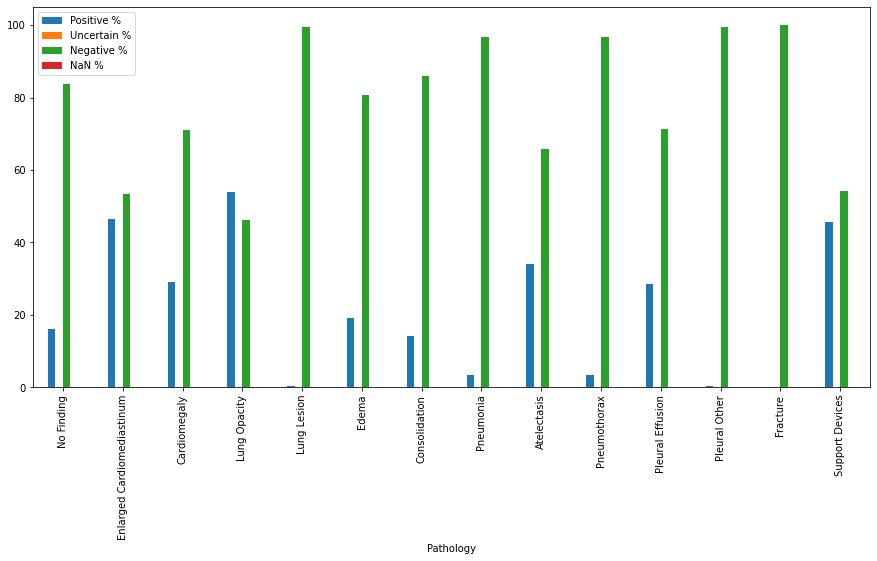

In [29]:
get_label_distribution(test_labels)[['Positive %', 'Uncertain %', 'Negative %', 'NaN %']].copy().plot(kind='bar', figsize=(15,7))

In addition to the labels, we have patient-related features and picture metadata in the dataset.

In [17]:
column_names = np.array(train_labels.columns)
print('Patient Information: ', column_names[2:4])
print('Metadata: ', column_names[4:6])

Patient Information:  ['Age' 'Frontal/Lateral']
Metadata:  ['AP/PA' 'No Finding']


## Images

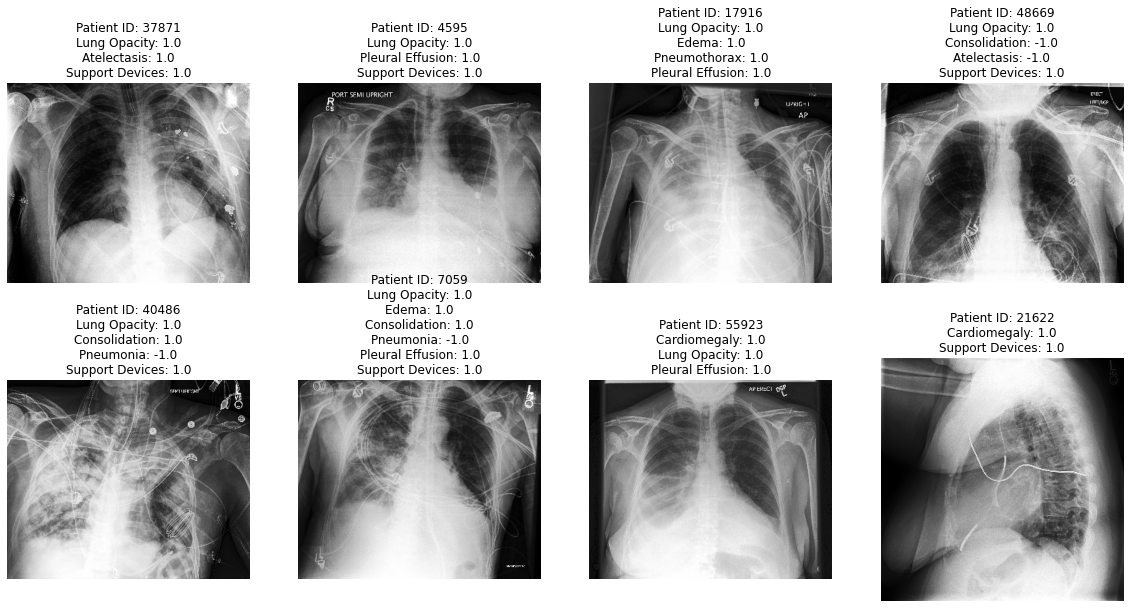

In [19]:
# Randomly sample 8 images
imgs = train_labels['Path'].to_numpy()
imgs_samples = train_labels.sample(n=8, random_state=1)

# Plot random sample of 8 images
plt.figure(figsize=(20, 10))
for i in range(len(imgs_samples)):
    img = cv2.imread(str(chexpert_folder / imgs_samples.Path.to_list()[i]))
    title = "Patient ID: " + str(imgs_samples['patient_id'].to_list()[i])
    for label in labels:
        label_value = imgs_samples[label].to_list()[i]
        if label_value != 0.0 and not math.isnan(label_value):
            title += '\n' + label + ': ' + str(imgs_samples[label].to_list()[i])
    # Plot the image
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
plt.show()


The pictures in the dataset are of varying size, so we take a look at the dimensions of the images. This information needs to be
considered when preprocessing the dataset.

In [20]:
# Prints all the different dimensions that images have
frontal_dimensions = []
lateral_dimensions = []
for index, row in train_labels.iterrows():
    image = cv2.imread(str(chexpert_folder / row['Path']))
    if row['Frontal/Lateral'] == 'Frontal':
        frontal_dimensions.append((image.shape[0], image.shape[1]))
    else:
        lateral_dimensions.append((image.shape[0], image.shape[1]))

In [32]:
frontal = pd.Series(frontal_dimensions)
frontal.value_counts()

NameError: name 'frontal_dimensions' is not defined

In [22]:
lateral = pd.Series(lateral_dimensions)
lateral.value_counts()

(320, 320)    8629
(390, 320)    5657
(369, 320)    4925
(371, 320)    2063
(368, 320)     704
              ... 
(320, 405)       1
(320, 379)       1
(320, 395)       1
(486, 320)       1
(474, 320)       1
Length: 249, dtype: int64

['No Finding',
 'Enlarged Cardiomediastinum',
 'Cardiomegaly',
 'Lung Opacity',
 'Lung Lesion',
 'Edema',
 'Consolidation',
 'Pneumonia',
 'Atelectasis',
 'Pneumothorax',
 'Pleural Effusion',
 'Pleural Other',
 'Fracture',
 'Support Devices']